# Multi-Class Classification of RetinaMNIST Dataset with ResNet50 Model

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [21]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns


In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.utils import shuffle

In [23]:
# Import ResNet50 (pretrained)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


In [24]:
#data = np.load('/content/drive/MyDrive/mnist_medical_images/retinamnist.npz')
data = np.load('/data/retinamnist.npz')
print(data.files)  # shows stored arrays like ['images', 'labels']

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [25]:
# Extract arrays
x_train = data['train_images']
y_train = data['train_labels']
x_val   = data['val_images']
y_val   = data['val_labels']
x_test  = data['test_images']
y_test  = data['test_labels']

## Analyze Dataset

In [26]:
# check shapes
print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape, y_val.shape)
print("Test: ", x_test.shape, y_test.shape)

Train: (1080, 28, 28, 3) (1080, 1)
Val:   (120, 28, 28, 3) (120, 1)
Test:  (400, 28, 28, 3) (400, 1)


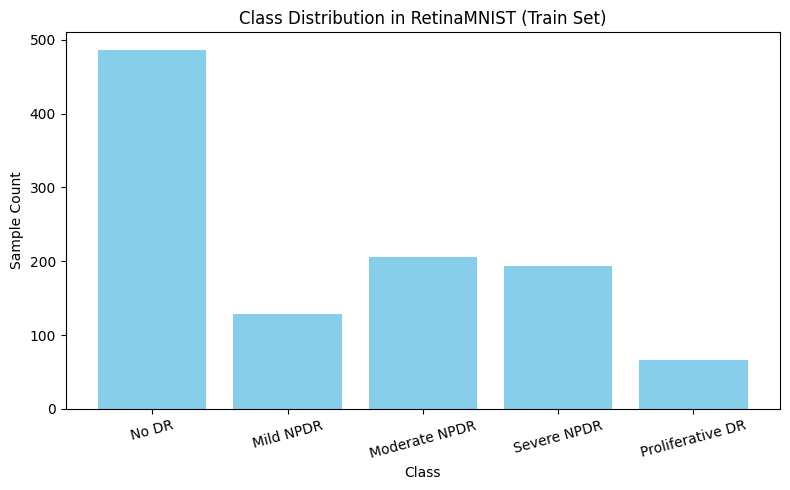

In [27]:
# Count occurrences of each class
class_names = ['No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR']
unique, counts = np.unique(y_train, return_counts=True)

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(class_names, counts, color='skyblue')
plt.title("Class Distribution in RetinaMNIST (Train Set)")
plt.xlabel("Class")
plt.ylabel("Sample Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## Data Pre-processing

 pretrained ResNet expects RGB images are of shape (224, 224, 3). Therefore need to resize images into 224*224.

In [28]:
# resize for ResNet
x_train_resized = tf.image.resize(x_train, [224, 224])
x_val_resized   = tf.image.resize(x_val, [224, 224])
x_test_resized  = tf.image.resize(x_test, [224, 224])



## **Apply Class-Balanced Augmentation**

The order of augmentation and standardization can vary depending on the framework.  For ResNet must match ImageNet preprocessing. Hence -> resize, augment, standardize

In [29]:
# define augmentor
augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)


In [30]:
y_train.shape

(1080, 1)

In [31]:
# flatten y
y_train_labels = y_train.flatten()
y_val_labels = y_val.flatten()
y_test_labels = y_test.flatten()

# Find minority classes
unique, counts = np.unique(y_train_labels, return_counts=True)
mean_count = np.mean(counts)
minority_classes = [cls for cls, cnt in zip(unique, counts) if cnt < mean_count]


In [32]:
# Generate augmented samples
augmented_images, augmented_labels = [], []
target_per_class = int(mean_count)

x_train_resized = x_train_resized.numpy()  # Convert Tensor to NumPy array




for cls in minority_classes:
    cls_indices = np.where(y_train_labels == cls)[0]
    x_cls = x_train_resized[cls_indices]
    y_cls = y_train_labels[cls_indices]

    gen = augmentor.flow(x_cls, y_cls, batch_size=1)
    for _ in range(target_per_class - len(x_cls)):
        x_aug, y_aug = next(gen)
        augmented_images.append(x_aug[0])
        augmented_labels.append(y_aug[0])

In [33]:
# Combine with original
x_train_balanced = np.concatenate([x_train_resized] + [augmented_images], axis=0)
y_train_balanced = np.concatenate([y_train_labels] + [augmented_labels], axis=0)

In [35]:

x_train_balanced, y_train_balanced = shuffle(x_train_balanced, y_train_balanced, random_state=42)


In [36]:
# normalization
from tensorflow.keras.applications.resnet50 import preprocess_input

x_train_processed = preprocess_input(x_train_balanced) # normalizes the image pixel values to match resnet50 model
x_val_processed = preprocess_input(x_val_resized)
x_test_processed = preprocess_input(x_test_resized)



# **Build ResNet for RetinaMNIST**

In [37]:
# Import ResNet50 (pretrained)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models


In [38]:
# Build Model with a Custom Classification Head

# Load the base ResNet50 without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])


In [39]:
# Compile the Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse since labels are integer encoded
    metrics=['accuracy']
)


## Training

In [40]:
# Train the Model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    x_train_processed, y_train_balanced,
    validation_data=(x_val_processed, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 299s 7s/step - accuracy: 0.3602 - loss: 1.7898 - val_accuracy: 0.5083 - val_loss: 1.1620
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 297s 6s/step - accuracy: 0.4477 - loss: 1.2945 - val_accuracy: 0.4917 - val_loss: 1.1043
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 348s 7s/step - accuracy: 0.4977 - loss: 1.2233 - val_accuracy: 0.4417 - val_loss: 1.1160
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 297s 6s/step - accuracy: 0.5304 - loss: 1.1758 - val_accuracy: 0.4667 - val_loss: 1.1943


## Evaluation

In [42]:
# Evaluate
results = model.evaluate(x_test_processed, y_test)

for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")



13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.4656 - loss: 1.1958
loss: 1.2260
compile_metrics: 0.4675


In [43]:

y_pred_probs = model.predict(x_test_processed) #Predict probabilities on test set. Returns softmax output for each class


y_pred = np.argmax(y_pred_probs, axis=1)  # Converts softmax probabilities into predicted class labels (integers).
y_true = y_test.flatten() # ensure that the test labels are in the correct 1D shape

13/13 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step


In [44]:
# Classification report
label_names = ['No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR']

print(" Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))

 Classification Report:

                  precision    recall  f1-score   support

           No DR       0.64      0.80      0.71       174
       Mild NPDR       0.27      0.09      0.13        46
   Moderate NPDR       0.29      0.30      0.30        92
     Severe NPDR       0.31      0.15      0.20        68
Proliferative DR       0.16      0.30      0.21        20

        accuracy                           0.47       400
       macro avg       0.33      0.33      0.31       400
    weighted avg       0.44      0.47      0.44       400



In [45]:
# ROC AUC (macro and micro)
y_true_onehot = to_categorical(y_true, num_classes=5)

auc_macro = roc_auc_score(y_true_onehot, y_pred_probs, average='macro', multi_class='ovr')
auc_micro = roc_auc_score(y_true_onehot, y_pred_probs, average='micro', multi_class='ovr')

print(f"Micro AUC: {auc_micro:.3f}")
print(f"Macro AUC: {auc_macro:.3f}")




Micro AUC: 0.795
Macro AUC: 0.727
